In [21]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
import proplot as pplt
import scipy.signal
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)

## By downloading the master CSV file enumerating all available data stores, we can interact with the spreadsheet
## through a pandas DataFrame to search and explore for relevant data using the CMIP6 controlled vocabulary:
    
df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

In [3]:
def getData(qstring):
    df_subset = df.query(qstring)
    if df_subset.empty:
        print('data not available for '+qstring)
    else:
        for v in df_subset.zstore.values:
            zstore = v
            mapper = fs.get_mapper(zstore)
            return_ds = xr.open_zarr(mapper, consolidated=True)
    return(return_ds)

In [4]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def removeSC(x):
    return x.groupby('time.month').apply(remove_time_mean)
    
def detrend(x,dim):
    y=x.copy()
    y.values=scipy.signal.detrend(x,dim)
    return y

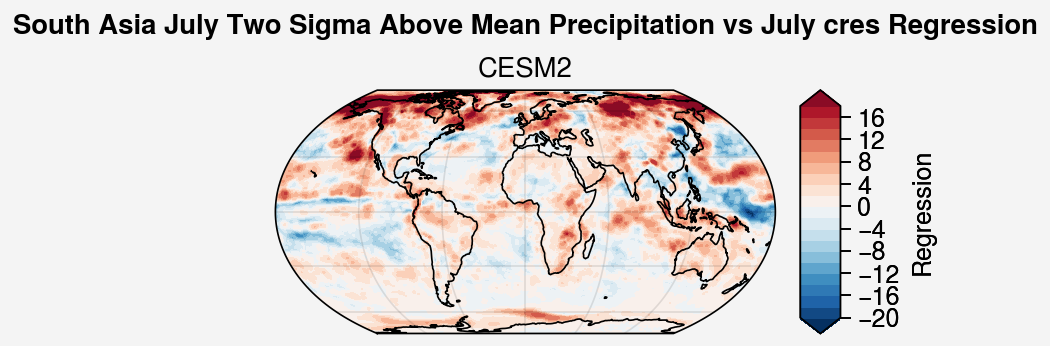

In [28]:
modelNames=['CESM2']

fig,axes = pplt.subplots([[1]],proj='eqearth')
for i,name in enumerate(modelNames):
    inputStr    = "activity_id=='CMIP' & table_id=='Amon' & experiment_id=='historical' &  member_id=='r1i1p1f1' & variable_id=="
    altinputStr = "activity_id=='CMIP' & table_id=='fx' & experiment_id=='historical' &  member_id=='r1i1p1f1' & variable_id=="
    rsut_ds   = getData(inputStr+"'rsut'")
    pr_ds     = getData(inputStr+"'pr'")
    rsutcs_ds = getData(inputStr+"'rsutcs'")
    sftlf_ds = getData(altinputStr+"'sftlf'")
    
    cres= rsutcs_ds.rsutcs-rsut_ds.rsut
    
    # remove Seasonal Cycle
    cres_RSC=removeSC(cres)
    # Detrend
    cres_RSC_dt=detrend(cres_RSC,0)
    cres_Pre_ds = xr.Dataset({'cres': (('time','lat','lon'), cres_RSC_dt.data, {'long_name':'Cloud radiative effect in shortwave', 'units' :'W m-2', 'Description':'(rsdt - rsut) - (rsdt - rsutcs)'})}, coords={'time': cres.time,'lat': cres.lat,'lon': cres.lon})
    
    
    # Precip
    pr= pr_ds.pr
    # Preprocessing
    # remove Seasonal Cycle
    pr_RSC=removeSC(pr)
    #Detrend
    pr_RSC_dt=detrend(pr_RSC,0)
    pr_Pre_ds = xr.Dataset({'pr': (('time','lat','lon'), pr_RSC_dt.data,{'long_name':pr.long_name, 'units':pr.units})}, coords={'time': pr.time,'lat': pr.lat,'lon': pr.lon})
    
    cres=cres_Pre_ds.cres

    cres=cres[1548:,:,:]

    lons=cres.lon
    lats=cres.lat

    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex

    
    land=sftlf_ds.sftlf
    landlon=land.lon
    landlat=land.lat
    
    land=land.to_numpy()
    prec=pr_Pre_ds.pr
    #Regrid land to model dimensions because they aren't the same for some reason???
    X, Y =np.meshgrid(landlon,landlat)
    lats=prec.lat
    lons=prec.lon
    XI,YI=np.meshgrid(lons,lats)
    
    regridland=griddata((X.flatten(),Y.flatten()), land.flatten(), (XI,YI), method='nearest')
    
    precip=xr.where(regridland==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    time=time.to_numpy()

    time=time.astype(int)/10**9

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    #Do weighted correction on precipitation
    weights=np.cos(np.deg2rad(prec.lat))
    prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))
    prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean
    
    pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed
    
    #Calculate variable correlations
    corr=xr.corr(pr_new,cres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    
    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(regression.lon,regression.lat,regression,levels=np.arange(-20,20,2),extend='both')
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July Two Sigma Above Mean Precipitation vs July cres Regression')
cbar.set_label('Regression')
    

ValueError: indexes along dimension 'lat' are not equal

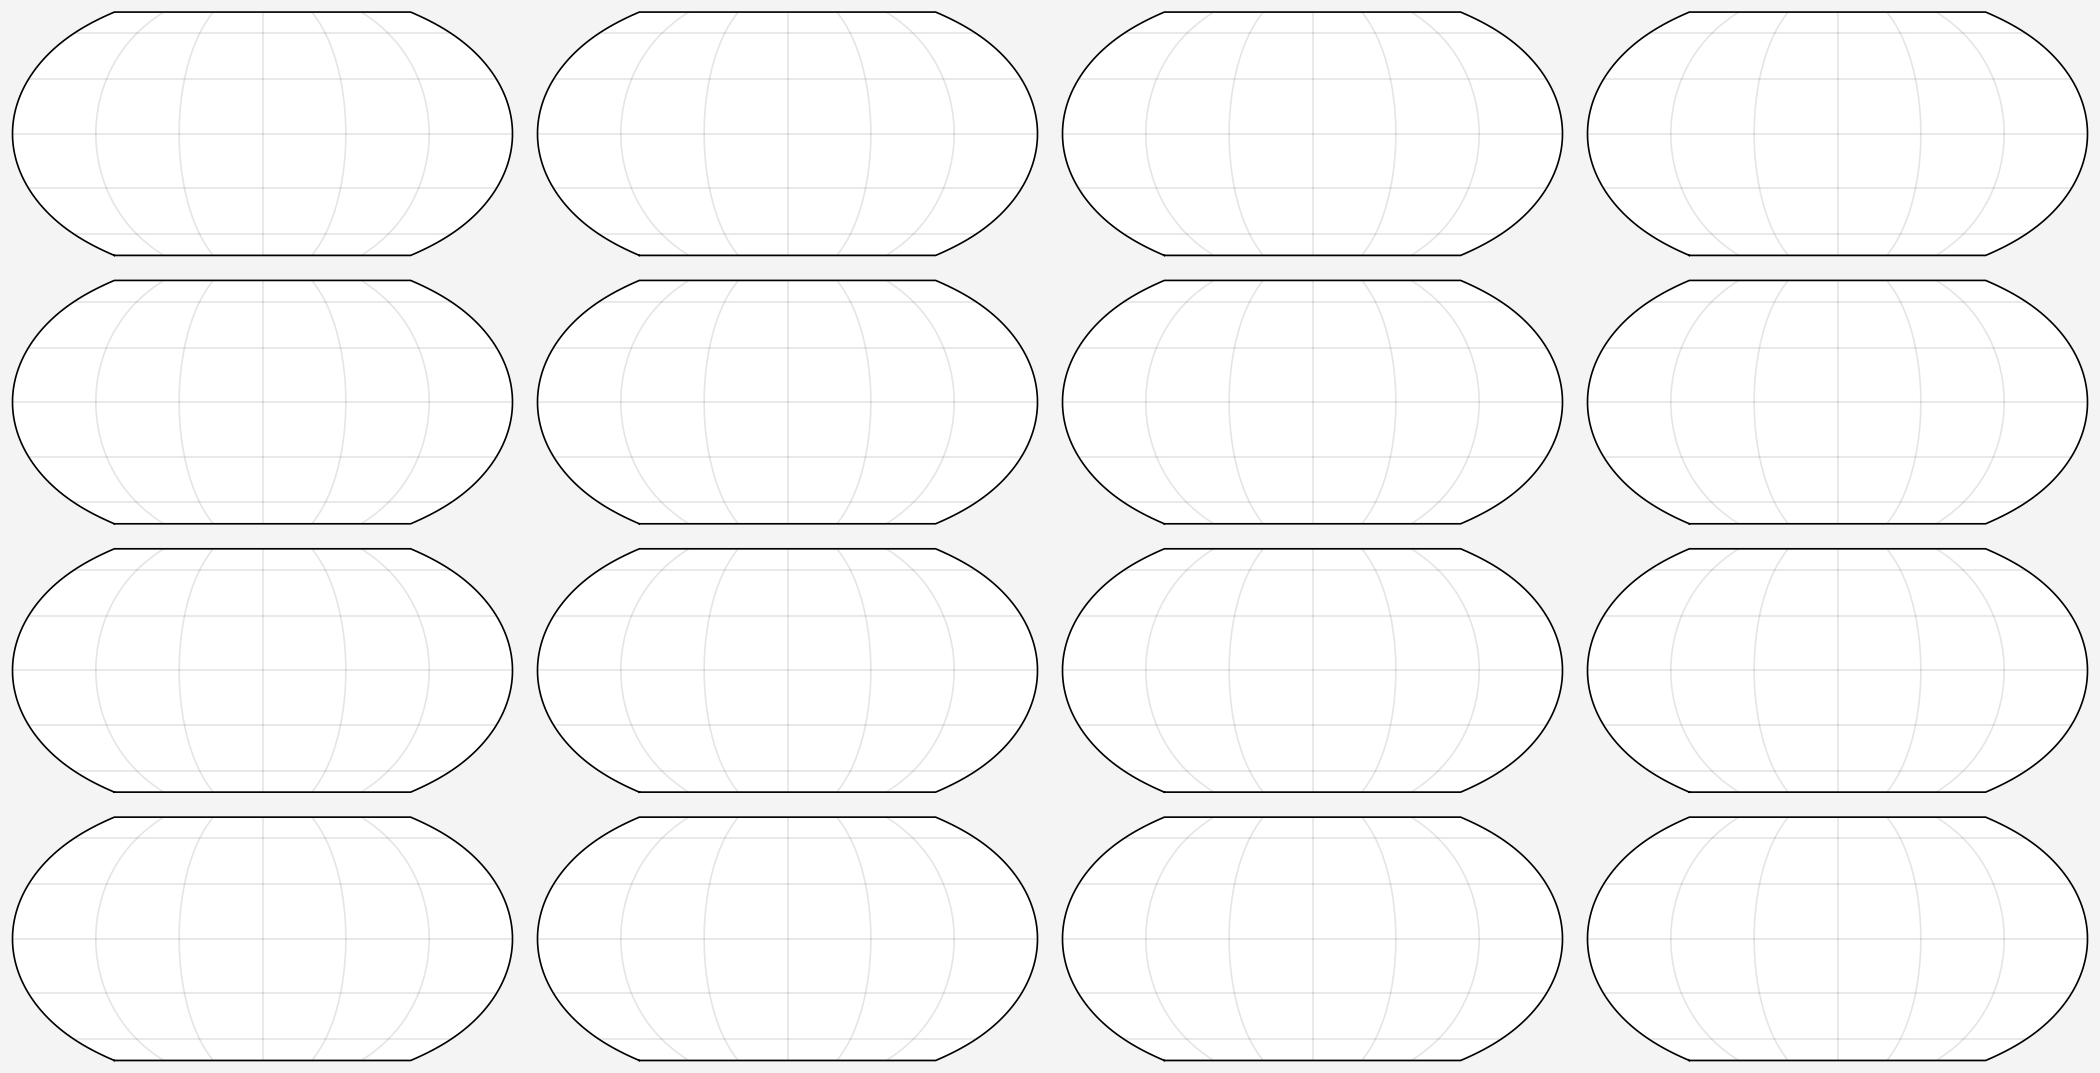

In [15]:
modelNames=['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CanESM5',
'E3SM-1-1','E3SM-1-1-ECA','GFDL-CM4','GFDL-ESM4','GISS-E2-1-H','MIROC-ES2L','MIROC6'
,'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MRI-ESM2-0']

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],proj='eqearth')
for i,name in enumerate(modelNames):
    inputStr  = "activity_id=='CMIP' & table_id=='Amon' & experiment_id=='historical' &  member_id=='r1i1p1f1' & variable_id=="
    altinputStr  = "activity_id=='CMIP' & table_id=='fx' & experiment_id=='historical' &  member_id=='r1i1p1f1' & variable_id=="
    rsut_ds   = getData(inputStr+"'rsut'")
    rsut_ds   = getData(inputStr+"'rsut'")
    pr_ds     = getData(inputStr+"'pr'")
    rsdt_ds   = getData(inputStr+"'rsdt'")
    rsutcs_ds = getData(inputStr+"'rsutcs'")
    sftlf_ds = getData(altinputStr+"'sftlf'")
    
    cres= rsutcs_ds.rsutcs-rsut_ds.rsut
    
    # remove Seasonal Cycle
    cres_RSC=removeSC(cres)
    # Detrend
    cres_RSC_dt=detrend(cres_RSC,0)
    cres_Pre_ds = xr.Dataset({'cres': (('time','lat','lon'), cres_RSC_dt.data, {'long_name':'Cloud radiative effect in shortwave', 'units' :'W m-2', 'Description':'(rsdt - rsut) - (rsdt - rsutcs)'})}, coords={'time': cres.time,'lat': cres.lat,'lon': cres.lon})
    
    
    # Precip
    pr= pr_ds.pr
    # Preprocessing
    # remove Seasonal Cycle
    pr_RSC=removeSC(pr)
    #Detrend
    pr_RSC_dt=detrend(pr_RSC,0)
    pr_Pre_ds = xr.Dataset({'pr': (('time','lat','lon'), pr_RSC_dt.data,{'long_name':pr.long_name, 'units':pr.units})}, coords={'time': pr.time,'lat': pr.lat,'lon': pr.lon})
    
    cres=cres_Pre_ds.cres

    cres=cres[1548:,:,:]

    lons=cres.lon
    lats=cres.lat

    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex

    
    #Done getting input variables, now get output variables - precipition
    prec=pr_Pre_ds.pr
    land=sftlf_ds.sftlf
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    #Do weighted correction on precipitation
    weights=np.cos(np.deg2rad(prec.lat))
    prec_index=prec_july.weighted(weights).mean(dim=('lat','lon'))
    prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean
    
    pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed
    
    #Calculate variable correlations
    corr=xr.corr(pr_new,cres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    
    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,extend='both')
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July Two Sigma Above Mean Precipitation vs July cres Regression')
cbar.set_label('Regression')
